<a href="https://colab.research.google.com/github/RGivisiez/Olist-sellers-K-Means/blob/main/E_Commerce_Seller.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A Olist é uma empresa de marketplace brasileira que agrega vendedores e divulga seus produtos. Diversas análilses de seu dataset já foram feitas e podem ser encontradas nesta página do [Kaggle](https://www.kaggle.com/olistbr/brazilian-ecommerce). Seu dataset contêm mais de 100.000 ordens de vendas feitas por mais de 1.000 vendedores.

Neste notebook, vamos separar os vendedores utilizando as avaliações dos usuários. Porém, isso vai ser feito por um algoritmo não supervisionado chamado K-Means. A ideia é que o algoritmo consiga, sozinho, identificar características de bons e maus vendedores. Essas características podem ser utilizadas para ajudar a melhorar as avaliações de vendedores com notas baixas e também para dar bonificações para vendedores com notas altas.


### Python Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

In [ ]:
%cd Dataset/o-list

/project/Dataset/o-list


### Funções auxiliares



In [ ]:
def plot_silhouette_scores(models, data):

  silhouette_scores = []
  ks = []

  for model in models:
    model.fit(data)
    silhouette_scores.append(silhouette_score(data, model.labels_))
    ks.append(model.n_clusters)

  plt.figure(figsize=(8, 3))
  plt.plot(ks, silhouette_scores, "bo-")
  plt.xlabel("n_cluster", fontsize=14)
  plt.ylabel("Silhouette score", fontsize=14)

  plt.show()

#Abrindo os dados

A separação entre os datasets disponibilizados é dada por:


![a](https://i.imgur.com/HRhd2Y0.png)

### Abrindo os datasets, menos o que contêm os dados de geolocalização.


In [ ]:
products = pd.read_csv('olist_products_dataset.csv')
category_translation = pd.read_csv('product_category_name_translation.csv')

items = pd.read_csv("olist_order_items_dataset.csv")
items.rename(columns={'order_item_id':'order_item_qty'}, inplace=True)

orders = pd.read_csv("olist_orders_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
#geoloc = pd.read_csv("olist_geolocation_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")
customers = pd.read_csv("olist_customers_dataset.csv")

### Trocando os nomes dos produtos para inglês



In [ ]:
products = pd.merge(products, category_translation, how="left", 
                    on="product_category_name")

products.drop('product_category_name', axis=1, inplace=True)
products.rename(columns={'product_name_lenght':'product_name_length',
                         'product_description_lenght':'product_description_length',
                         'product_category_name_english':'product_category_name'},
                inplace=True)

del category_translation

### Unificando todos os dados

In [ ]:
df = pd.merge(orders, payments, on='order_id', how='left')
df = pd.merge(df, reviews, on='order_id', how='left')
df = pd.merge(df, items, on='order_id', how='left')
df = pd.merge(df, customers, on='customer_id', how='left')
df = pd.merge(df, products, on='product_id', how='left')
df = pd.merge(df, sellers, on='seller_id', how='left')
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,...,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,credit_card,...,268.0,4.0,500.0,19.0,8.0,13.0,housewares,9350.0,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,3.0,voucher,...,268.0,4.0,500.0,19.0,8.0,13.0,housewares,9350.0,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2.0,voucher,...,268.0,4.0,500.0,19.0,8.0,13.0,housewares,9350.0,maua,SP
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,boleto,...,178.0,1.0,400.0,19.0,13.0,19.0,perfumery,31570.0,belo horizonte,SP
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,credit_card,...,232.0,1.0,420.0,24.0,19.0,21.0,auto,14840.0,guariba,SP


# Criando novas variáveis e descartando variáveis que não serão utilizadas

A ideia é considerar somente variáveis relacionadas a satisfação do cliente e que descrevem características dos vendedores. Porém, isso não vai incluir variáveis relacionadas ao CEP ou estados, essas variáveis tendem a ser identificadas muito facilmente pelo K-Means e se tornam a característica principal de cada grupo.

### Variável atraso na entrega

- A variável `delivery_delay` vai medir a diferença entre o dia da entrega anunciada para o consumidor e o dia que de fato a entrega chegou.

In [ ]:
df['order_delivered_carrier_date'] = pd.to_datetime(df['order_delivered_carrier_date'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])

df['delivery_delay'] = (df['order_delivered_customer_date'] - df['order_delivered_carrier_date']).dt.days

### Variável densidade do produto

- O peso do produto pode ser um fator decisivo para a demora ou a dificuldade da entrega.

In [ ]:
df['product_density'] = df['product_weight_g'] / (df['product_width_cm'] * df['product_length_cm'] * df['product_height_cm'])

### Variável com a diferença entre o dia que o pedido deve chegar e o dia que o usuário postou sua avaliação


In [ ]:
df['review_creation_date'] = pd.to_datetime(df['review_creation_date'])
df['review_delay'] = (df['review_creation_date'] - df['order_delivered_customer_date']).dt.days

### Variável com o número de letras do comentário deixado pelo usuário

- Provavelmente, comentários longos estarão correlacionados com notas baixas dos usuários.

In [ ]:
df['review_comment_length'] = df['review_comment_message'].apply(lambda x: len(x) if type(x) == str else np.nan)

### Descarte de variáveis que não serão utilizadas

In [ ]:
drop_cols = ['order_purchase_timestamp', 'order_approved_at',
             'order_delivered_carrier_date',	'order_delivered_customer_date',
             'order_estimated_delivery_date',
              
             'product_weight_g', 'product_length_cm',
             'product_height_cm','product_width_cm',

             'payment_sequential', 'payment_type', 
             'payment_installments', 'payment_value',

             'customer_id', 'customer_city', 'customer_state',
             'customer_unique_id', 'customer_zip_code_prefix',

             'seller_zip_code_prefix', 'seller_state',
             'seller_city', 'shipping_limit_date',

             'review_comment_title', 'review_comment_message',
             'review_creation_date', 'review_answer_timestamp',
             'review_id',
             ]

df.drop(drop_cols, axis=1, inplace=True)
df.dropna(inplace=True)

### Descarte de entregas que não foram feitas

In [ ]:
df = df[df.order_status == 'delivered'].drop('order_status', axis=1)

### O dataset

In [ ]:
df.head()

,order_id,review_score,order_item_qty,product_id,seller_id,price,freight_value,product_name_length,product_description_length,product_photos_qty,product_category_name,delivery_delay,product_density,review_delay,review_comment_length
0,e481f51cbdc54678b7cc49136f2d6af7,4.0,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,40.0,268.0,4.0,housewares,6.0,0.253036,0.0,170.0
1,e481f51cbdc54678b7cc49136f2d6af7,4.0,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,40.0,268.0,4.0,housewares,6.0,0.253036,0.0,170.0
2,e481f51cbdc54678b7cc49136f2d6af7,4.0,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,40.0,268.0,4.0,housewares,6.0,0.253036,0.0,170.0
3,53cdb2fc8bc7dce0b6741e2150273451,4.0,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,118.70,22.76,29.0,178.0,1.0,perfumery,12.0,0.085233,0.0,20.0
5,949d5b44dbf5de918fe9c16f97b45f8a,5.0,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,45.00,27.20,59.0,468.0,3.0,pet_shop,9.0,0.075000,0.0,105.0


#Criando o dataset dos vendedores

### Fazendo o One Hot Enconde (OHE) das categorias dos produtos

- Isso pode ajudar o algoritmo a identificar características sobre o tipo de loja que o vendedor possui.

In [ ]:
onehot = pd.get_dummies(df['product_category_name'])

In [ ]:
df_sellers_gp = pd.concat([df, onehot], axis=1).drop('product_category_name', axis=1)

### Agrupando os dados de cada vendedor

In [ ]:
agg_dict = {'order_id':'nunique',
            'product_id':'nunique',
            'review_score':'mean',
            'order_item_qty':'mean',
            'freight_value':'mean',
            'product_name_length':'mean',
            'product_description_length':'mean',
            'product_photos_qty':'mean',
            'price':'mean',
            'delivery_delay':'mean',
            'product_density':'mean',
            'review_delay':'mean',
            'review_comment_length':'mean',
            }

agg_dict.update({key: 'sum' for key in onehot.columns})

In [ ]:
df_sellers_gp = pd.concat([df, onehot], axis=1).groupby('seller_id').agg(agg_dict)

In [ ]:
df_sellers_gp.rename(columns={'order_id':'sales_unique', 
                              'product_id':'product_unique'}, inplace=True)

In [ ]:
df_sellers_gp.head()

,sales_unique,product_unique,review_score,order_item_qty,freight_value,product_name_length,product_description_length,product_photos_qty,price,delivery_delay,...,security_and_services,signaling_and_security,small_appliances,small_appliances_home_oven_and_coffee,sports_leisure,stationery,tablets_printing_image,telephony,toys,watches_gifts
seller_id,,,,,,,,,,,,,,,,,,,,,
0015a82c2db000af6aaaf3ae2ecb0532,1,1,1.000000,1.000000,21.020000,40.000000,849.000000,2.000000,895.000000,7.000000,...,0,0,1,0,0,0.0,0,0.0,0,0.0
001cca7ae9ae17fb1caed9dfb1094831,88,9,3.621622,1.315315,36.919910,36.027027,476.873874,1.720721,104.253874,8.981982,...,0,0,0,0,0,0.0,0,0.0,0,0.0
002100f778ceb8431b7a1020ff7ab48f,15,13,3.647059,1.058824,15.133529,54.529412,662.941176,1.000000,20.252941,12.117647,...,0,0,0,0,0,0.0,0,0.0,0,0.0
004c9cd9d87a3c30c522c48c4fc07416,55,39,3.809524,1.174603,19.758730,56.095238,523.809524,1.111111,116.877778,11.714286,...,0,0,0,0,0,0.0,0,0.0,0,0.0
00720abe85ba0859807595bbf045a33b,5,5,2.846154,2.769231,12.444615,46.538462,458.692308,1.846154,33.092308,6.923077,...,0,0,0,0,0,0.0,0,0.0,0,0.0


# Correlação linear entre as variáveis

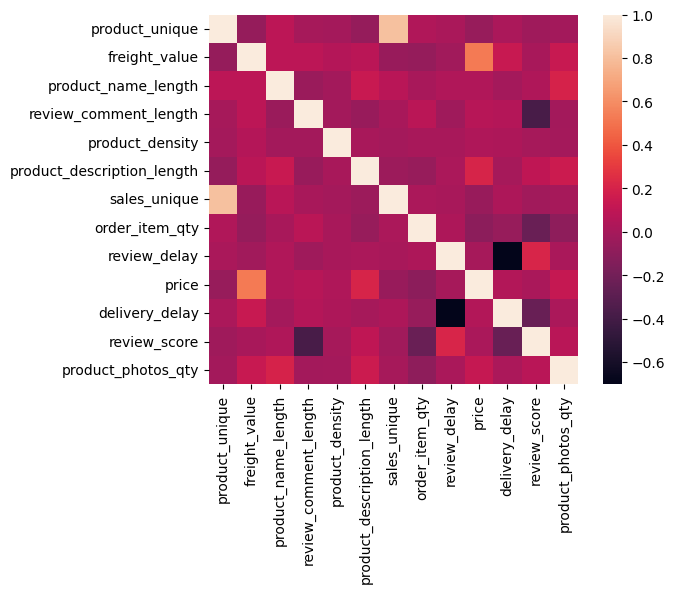

In [ ]:
#@title Heatmap Correlation

columns = set(df_sellers_gp.columns) - set(onehot.columns)

corr = df_sellers_gp[columns].corr()

#plt.figure(figsize=(10, 10))

sns.heatmap(corr, vmax=1.0, square=True, fmt='.2f', annot_kws={'size': 8}, annot=False);
plt.show()

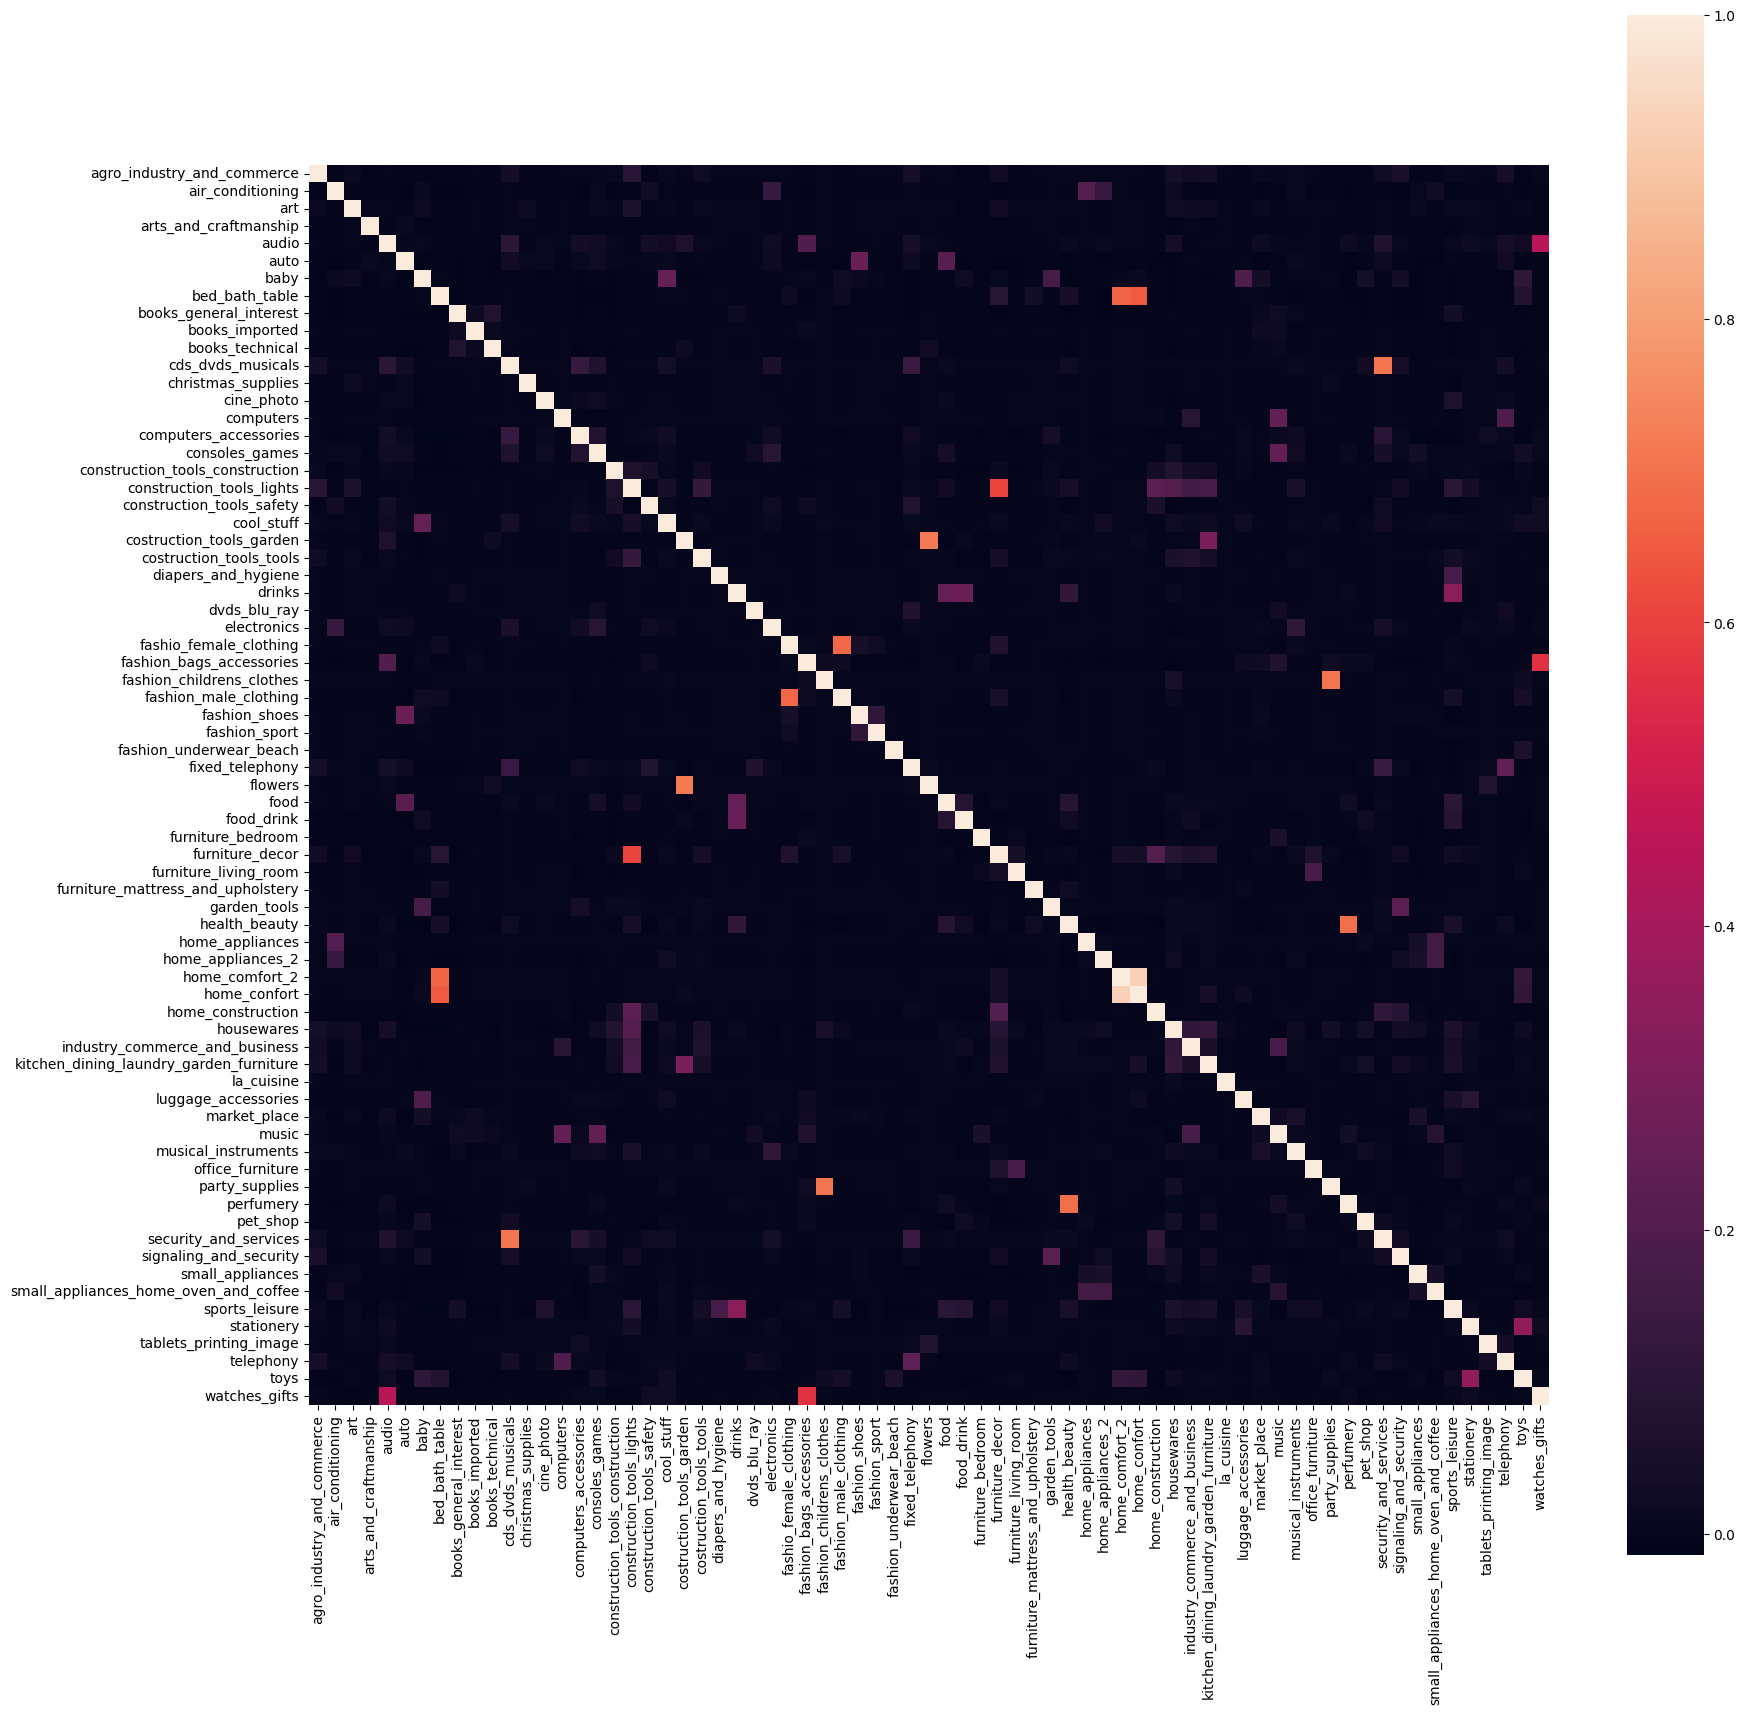

In [ ]:
#@title Heatmap Correlation

columns = onehot.columns

prod_corr = df_sellers_gp[columns].corr()

plt.figure(figsize=(20, 20))

sns.heatmap(prod_corr, vmax=1.0, square=True, fmt='.2f', annot_kws={'size': 8}, annot=False);
plt.show()

### Descartando variáveis correlacionadas

- A variável `review_delay` será descartada já que está altamente correlacionada com a variável `delivery_delay`.

- Existem alguns produtos que estão correlacionados como `home_confort` e `home_comfort_2`. Todos os produtos com correlação maior do que $0.7$ serão agrupados em um único produto.

In [ ]:
df_sellers_gp.drop('review_delay', axis=1, inplace=True)

In [ ]:
features_corr = {}

for column in prod_corr.columns:

  mask = (np.abs(prod_corr[column]) > 0.7) & (np.abs(prod_corr[column]) < 1)
  
  if mask.sum() > 0:
    features_corr[column] = prod_corr.loc[mask, column].index.to_list()
  
features_corr

{'cds_dvds_musicals': ['security_and_services'],
 'costruction_tools_garden': ['flowers'],
 'fashion_childrens_clothes': ['party_supplies'],
 'flowers': ['costruction_tools_garden'],
 'home_comfort_2': ['home_confort'],
 'home_confort': ['home_comfort_2'],
 'party_supplies': ['fashion_childrens_clothes'],
 'security_and_services': ['cds_dvds_musicals']}

In [ ]:
df_sellers_gp['cds_dvds_musicals'] = df_sellers_gp['cds_dvds_musicals'] + df_sellers_gp['security_and_services']
df_sellers_gp['costruction_tools_garden'] = df_sellers_gp['costruction_tools_garden'] + df_sellers_gp['flowers']
df_sellers_gp['home_confort'] = df_sellers_gp['home_comfort_2'] + df_sellers_gp['home_confort']
df_sellers_gp['party_supplies'] = df_sellers_gp['party_supplies'] + df_sellers_gp['fashion_childrens_clothes']

In [ ]:
drop = ['security_and_services',
        'flowers',
        'home_comfort_2',
        'fashion_childrens_clothes',
        ]

df_sellers_gp.drop(drop, axis=1, inplace=True)
onehot.drop(drop, axis=1, inplace=True)

### A variável com as avaliações do cliente tem alta correlação com:

1. review_comment_length
2. delivery_delay
3. order_item_qty
4. review_delay

In [ ]:
#@title Review Score Correlation

corr['review_score'].sort_values(ascending=False)

review_score                  1.000000
review_delay                  0.211320
product_description_length    0.095981
product_photos_qty            0.069213
product_name_length           0.030811
price                         0.015732
freight_value                 0.008122
product_density              -0.001353
sales_unique                 -0.021930
product_unique               -0.027166
order_item_qty               -0.241725
delivery_delay               -0.249813
review_comment_length        -0.377723
Name: review_score, dtype: float64

# K-means

### Fit K-Means

- Vou considerar o uso do K-Means com $2$ e $3$ clusters. Um número menor de cluster vai nos permitir interpretar as características de cada vendedor melhor.

In [ ]:
k_pipe = Pipeline([
                   ('MINMAX', MinMaxScaler([-1, 1])),
                  ])

k_pipe = k_pipe.fit(df_sellers_gp)
X = k_pipe.transform(df_sellers_gp) 

In [ ]:
min_k = 2
max_k = 4
dk = 1

kmeans_per_k = [KMeans(n_clusters=k, random_state=42) for k in range(min_k, max_k, dk)]

### Check the Silhouette Plot

- O plot da silhueta parece ser melhor quando utilizamos $2$ clusters.

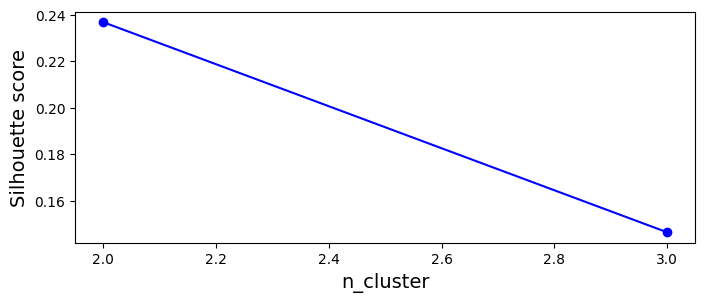

In [ ]:
#@title Silhouette Scores
plot_silhouette_scores(kmeans_per_k, X)

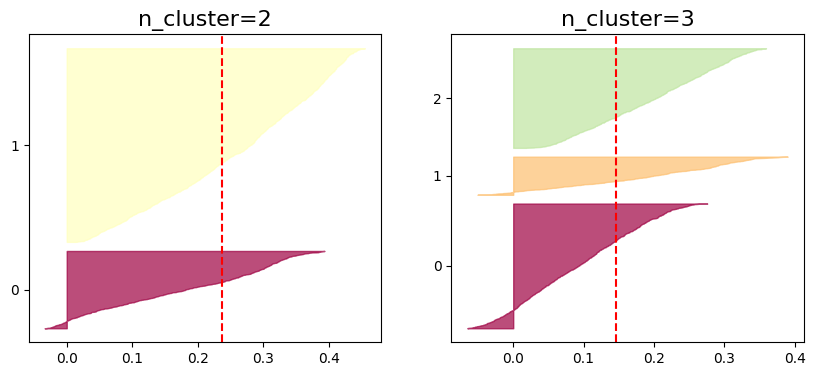

In [ ]:
#@title 

from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(10, 4))

for idx, _ in enumerate(range(len(kmeans_per_k))):

    y_pred = kmeans_per_k[idx].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)
    silhouette_avg = silhouette_score(X, y_pred)

    plt.subplot(1, 2, idx+1)
    padding = len(X) // 30
    pos = padding
    ticks = []

    for i in range(kmeans_per_k[idx].n_clusters):
            coeffs = silhouette_coefficients[y_pred == i]
            coeffs.sort()

            color = plt.cm.Spectral(i / kmeans_per_k[idx].n_clusters)
            plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                              facecolor=color, edgecolor=color, alpha=0.7)
            ticks.append(pos + len(coeffs) // 2)
            pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(15)))

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.title("n_cluster={}".format(kmeans_per_k[idx].n_clusters), fontsize=16)

plt.show()

Parece que dois cluster separam os dados melhor. Vamos ver se esses clusters conseguem separar os vendedores utilizando as notas dadas pelos usuários.

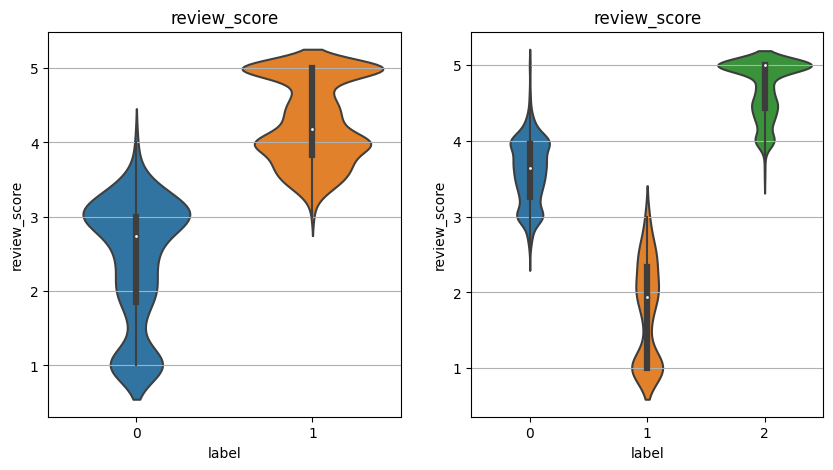

In [ ]:
#@title Notas dos usuários por cluster
plt.figure(figsize=[10, 5])

for idx, model in enumerate(kmeans_per_k):

  plt.subplot(1, 2, idx + 1)

  df_sellers_gp['label'] = model.labels_

  sns.violinplot(x = df_sellers_gp['label'], y = df_sellers_gp['review_score'])
  plt.title('review_score')
  plt.grid(True, axis='y')
  plt.xlabel('label')

plt.show()

O algoritmo consegue identificar os vendedores utilizando as notas dos usuários. Porém, ao utilizarmos $3$ clusters temos uma interpretação melhor já que cada cluster separa os vendedores com baixa, média e alta notas. A partir daqui, usarei o K-Means com $3$ clusters para as análises


### Identificando as características de cada cluster

- Ao agruparmos os dados de cada vendedor dentro de cada um dos cluster conseguimos identificar quais características definem cada cluster.

In [ ]:
# Rules to group every column.
oh_agg_dict = {key: 'sum' for key in onehot.columns} 

not_product_cols = set(df_sellers_gp.columns) - set(onehot.columns)
agg_dict = {key: 'mean' for key in not_product_cols}

agg_dict.update(oh_agg_dict)

In [ ]:
agg_df = df_sellers_gp.groupby('label').agg(agg_dict).drop('label', axis=1)
agg_df.iloc[:, :12]

,product_unique,freight_value,product_name_length,review_comment_length,product_density,product_description_length,sales_unique,order_item_qty,price,delivery_delay,review_score,product_photos_qty
label,,,,,,,,,,,,
0,12.719329,24.249773,48.959453,73.208366,0.202643,821.776669,28.842012,1.180642,164.346835,9.343892,3.593675,2.316186
1,3.115274,23.694192,44.978442,98.883793,0.226567,760.927080,5.135447,1.391861,191.844640,11.734704,1.748840,2.016869
2,3.433149,23.161679,45.195842,51.459104,0.209054,952.109832,5.287293,1.093616,192.149733,7.134137,4.701199,2.243016


Comparando o grupo com notas altas e baixas, vemos que os vendedores com notas possuem:

1. Comentários menores dos usuários,
2. Menor atraso na entrega,
3. Os produtos tem descrição maiores.

Essas características são consistentes com o grupo que possui notas medianas.

> A única característica que pode ser facilmente melhorada pela Olist é a previsão de entrega dos produtos. Podemos criar um modelo que ajude a prever os atrasos nas entregas.

# Conclusão

Vimos que o K-Means consegue separar os vendedores em grupo com notas baixas, médias e altas, sem a necessidade de interferência humana no processo de identificação. Além disso, ao olharmos para as características de cada grupo, percebemos que os vendedores com notas mais altas possuem comentário menores, descrição maiores dos produtos e um atraso na entrega menor.

A única característica que pode ser melhorada pela Olist é a previsão do prazo de entrega dos produtos. A Olist poderia criar um algoritmo para avisar o usuário de possíveis atrasos na entrega antes da compra.

